Using device: cpu

Label distribution:
binary_label
1    20620
0     4163
Name: count, dtype: int64


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training started...



Epoch 1/5: 100%|██████████| 1240/1240 [1:10:41<00:00,  3.42s/it, loss=0.838]  


Epoch 1: Loss=0.1337, Accuracy=0.9689, F1-score=0.9813


Epoch 2/5: 100%|██████████| 1240/1240 [1:10:33<00:00,  3.41s/it, loss=0.0057] 


Epoch 2: Loss=0.0748, Accuracy=0.9679, F1-score=0.9807


Epoch 3/5: 100%|██████████| 1240/1240 [1:21:20<00:00,  3.94s/it, loss=0.0318]   


Epoch 3: Loss=0.0460, Accuracy=0.9661, F1-score=0.9796


Epoch 4/5: 100%|██████████| 1240/1240 [1:02:22<00:00,  3.02s/it, loss=0.00246] 


Epoch 4: Loss=0.0257, Accuracy=0.9645, F1-score=0.9787


Epoch 5/5: 100%|██████████| 1240/1240 [55:37<00:00,  2.69s/it, loss=0.000168] 


Epoch 5: Loss=0.0171, Accuracy=0.9665, F1-score=0.9798


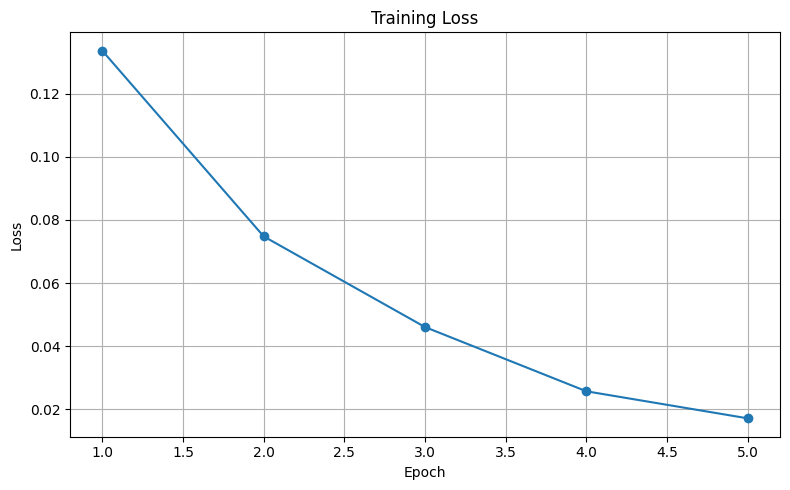

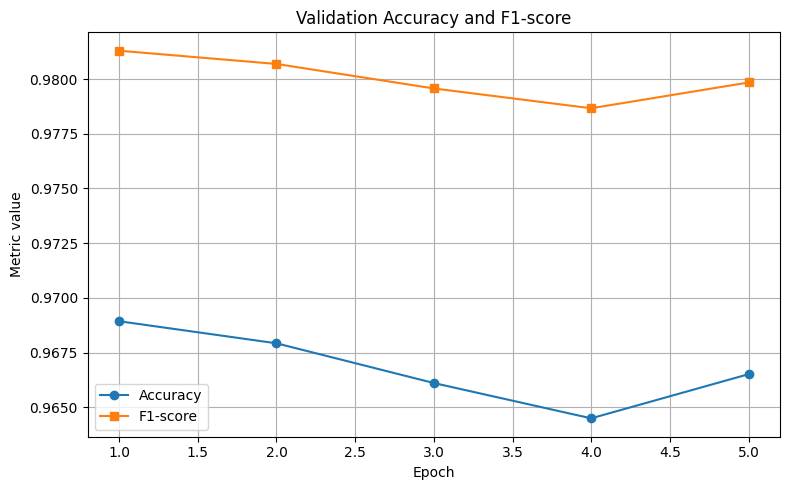


Training finished successfully.


In [2]:
import os
import torch
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from torch.optim import AdamW

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from tqdm.auto import tqdm

CSV_PATH = "labeled_data.csv"
MODEL_DIR = "model_with_metrics"

BATCH_SIZE = 16
EPOCHS = 5
MAX_LEN = 128
LR = 2e-5
RANDOM_STATE = 42

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

df = pd.read_csv(CSV_PATH).dropna()

if "tweet" in df.columns:
    text_col = "tweet"
elif "text" in df.columns:
    text_col = "text"
else:
    raise ValueError("Dataset must contain 'tweet' or 'text' column")

if "class" in df.columns:
    label_col = "class"
elif "label" in df.columns:
    label_col = "label"
else:
    raise ValueError("Dataset must contain 'class' or 'label' column")

df[text_col] = df[text_col].astype(str)
df["binary_label"] = df[label_col].apply(lambda x: 1 if x in [0, 1] else 0)

print("\nLabel distribution:")
print(df["binary_label"].value_counts())

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df[text_col].tolist(),
    df["binary_label"].tolist(),
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=df["binary_label"]
)

tokenizer = DistilBertTokenizerFast.from_pretrained(
    "distilbert-base-uncased"
)

class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        enc = tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=MAX_LEN,
            return_tensors="pt"
        )
        return {
            "input_ids": enc["input_ids"].squeeze(),
            "attention_mask": enc["attention_mask"].squeeze(),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }

train_loader = DataLoader(
    TextDataset(train_texts, train_labels),
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_loader = DataLoader(
    TextDataset(val_texts, val_labels),
    batch_size=BATCH_SIZE,
    shuffle=False
)

model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2
)
model.to(device)

optimizer = AdamW(model.parameters(), lr=LR)

train_losses = []
val_accuracies = []
val_f1_scores = []

print("\nTraining started...\n")

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")

    for batch in loop:
        optimizer.zero_grad()

        outputs = model(
            input_ids=batch["input_ids"].to(device),
            attention_mask=batch["attention_mask"].to(device),
            labels=batch["labels"].to(device)
        )

        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)

    model.eval()
    all_preds = []
    all_true = []

    with torch.no_grad():
        for batch in val_loader:
            logits = model(
                input_ids=batch["input_ids"].to(device),
                attention_mask=batch["attention_mask"].to(device)
            ).logits

            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_true.extend(batch["labels"].numpy())

    acc = accuracy_score(all_true, all_preds)
    f1 = f1_score(all_true, all_preds)

    val_accuracies.append(acc)
    val_f1_scores.append(f1)

    print(
        f"Epoch {epoch+1}: "
        f"Loss={avg_loss:.4f}, "
        f"Accuracy={acc:.4f}, "
        f"F1-score={f1:.4f}"
    )

os.makedirs(MODEL_DIR, exist_ok=True)
model.save_pretrained(MODEL_DIR)
tokenizer.save_pretrained(MODEL_DIR)

epochs = range(1, EPOCHS + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(epochs, val_accuracies, marker="o", label="Accuracy")
plt.plot(epochs, val_f1_scores, marker="s", label="F1-score")
plt.xlabel("Epoch")
plt.ylabel("Metric value")
plt.title("Validation Accuracy and F1-score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("\nTraining finished successfully.")
